In [1]:
# High Level implementation of Improved Markov model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class ImprovedHiddenMarkovModel:
    """
    An improved implementation of Hidden Markov Model with enhanced numerical stability,
    better initialization, and improved parameter estimation.
    """

    def __init__(self, n_states, n_features, random_state=None):
        """
        Initialize the Hidden Markov Model.

        Parameters:
        -----------
        n_states : int
            Number of hidden states
        n_features : int
            Number of observable features
        random_state : int or None
            Random seed for reproducibility
        """
        self.n_states = n_states
        self.n_features = n_features

        # Set random seed for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        # Initialize HMM parameters with better defaults
        # Initial state probabilities (π) - slightly break symmetry
        self.initial_probs = np.ones(n_states) / n_states
        self.initial_probs += np.random.rand(n_states) * 0.1
        self.initial_probs /= np.sum(self.initial_probs)

        # Transition probabilities (A) - initialized with high self-transition probabilities
        self.transition_probs = np.random.rand(n_states, n_states)
        # Add higher probability of staying in the same state
        np.fill_diagonal(self.transition_probs, np.diagonal(self.transition_probs) + 2.0)
        self.transition_probs = self.transition_probs / np.sum(self.transition_probs, axis=1, keepdims=True)

        # Emission parameters for Gaussian emissions - better initialization
        self.means = np.random.randn(n_states, n_features)

        # Covariance matrices for each state (assuming diagonal covariance)
        # Higher initial variance for better exploration
        self.covariances = np.ones((n_states, n_features)) * 1.0

    def _compute_emission_prob(self, X):
        """
        Compute the emission probabilities for observations using Gaussian distribution.
        Using log-probabilities for better numerical stability.

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Input data

        Returns:
        --------
        emission_prob : array, shape (n_samples, n_states)
            Emission probabilities (in log space)
        """
        n_samples = X.shape[0]
        log_emission_prob = np.zeros((n_samples, self.n_states))

        for s in range(self.n_states):
            # For each state, calculate log of multivariate Gaussian probability
            diff = X - self.means[s]
            log_exponent = -0.5 * np.sum((diff ** 2) / self.covariances[s], axis=1)
            log_norm_factor = -0.5 * np.sum(np.log(2 * np.pi * self.covariances[s]))
            log_emission_prob[:, s] = log_exponent + log_norm_factor

        return log_emission_prob

    def _forward(self, X):
        """
        Forward algorithm using log-space to compute the probability of observations.

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Input data

        Returns:
        --------
        log_alpha : array, shape (n_samples, n_states)
            Forward probabilities in log space
        """
        n_samples = X.shape[0]
        log_alpha = np.zeros((n_samples, self.n_states))

        # Compute emission probabilities in log space
        log_emission_prob = self._compute_emission_prob(X)

        # Initialization (in log space)
        log_alpha[0] = np.log(self.initial_probs + 1e-10) + log_emission_prob[0]

        # Forward recursion (in log space using the log-sum-exp trick)
        for t in range(1, n_samples):
            for s in range(self.n_states):
                # log(sum(exp(log(a_i) + log(b_ij)))) using log-sum-exp trick
                log_trans = np.log(self.transition_probs[:, s] + 1e-10)
                log_sum = self._log_sum_exp(log_alpha[t-1] + log_trans)
                log_alpha[t, s] = log_sum + log_emission_prob[t, s]

        return log_alpha

    def _log_sum_exp(self, log_probs):
        """
        Compute log(sum(exp(log_probs))) using the log-sum-exp trick for numerical stability.

        Parameters:
        -----------
        log_probs : array
            Log probabilities

        Returns:
        --------
        result : float
            log(sum(exp(log_probs)))
        """
        max_log_prob = np.max(log_probs)
        return max_log_prob + np.log(np.sum(np.exp(log_probs - max_log_prob)))

    def _backward(self, X):
        """
        Backward algorithm in log space.

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Input data

        Returns:
        --------
        log_beta : array, shape (n_samples, n_states)
            Backward probabilities in log space
        """
        n_samples = X.shape[0]
        log_beta = np.zeros((n_samples, self.n_states))

        # Compute emission probabilities in log space
        log_emission_prob = self._compute_emission_prob(X)

        # Initialization (in log space)
        # Beta values at the end are 1, which is 0 in log space
        log_beta[-1] = 0.0

        # Backward recursion (in log space)
        for t in range(n_samples - 2, -1, -1):
            for s in range(self.n_states):
                log_transition = np.log(self.transition_probs[s, :] + 1e-10)
                log_prob = log_transition + log_emission_prob[t+1, :] + log_beta[t+1, :]
                log_beta[t, s] = self._log_sum_exp(log_prob)

        return log_beta

    def _compute_posteriors(self, X):
        """
        Compute state posteriors P(z_t|X) and transition posteriors P(z_t-1,z_t|X).

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Input data

        Returns:
        --------
        state_posteriors : array, shape (n_samples, n_states)
            State posterior probabilities P(z_t|X)
        transition_posteriors : array, shape (n_states, n_states)
            Expected number of transitions from state i to state j
        initial_posteriors : array, shape (n_states,)
            Posterior probability of starting in each state
        """
        n_samples = X.shape[0]
        log_emission_prob = self._compute_emission_prob(X)

        # Get forward and backward variables in log space
        log_alpha = self._forward(X)
        log_beta = self._backward(X)

        # Compute log likelihood
        log_likelihood = self._log_sum_exp(log_alpha[-1])

        # Compute state posteriors (gamma) in log space then convert back to probability space
        log_gamma = log_alpha + log_beta - log_likelihood
        state_posteriors = np.exp(log_gamma)

        # Compute expected transitions
        transition_posteriors = np.zeros((self.n_states, self.n_states))

        for i in range(self.n_states):
            for j in range(self.n_states):
                for t in range(n_samples - 1):
                    # P(z_t=i, z_t+1=j | X) =
                    # alpha_t(i) * a_ij * b_j(x_t+1) * beta_t+1(j) / P(X)
                    log_xi_t = (log_alpha[t, i] +
                               np.log(self.transition_probs[i, j] + 1e-10) +
                               log_emission_prob[t+1, j] +
                               log_beta[t+1, j] -
                               log_likelihood)
                    transition_posteriors[i, j] += np.exp(log_xi_t)

        # Initial state posteriors
        initial_posteriors = state_posteriors[0]

        return state_posteriors, transition_posteriors, initial_posteriors

    def fit(self, X, max_iter=100, tol=1e-4, verbose=False):
        """
        Estimate HMM parameters using the Baum-Welch algorithm with improved numerical stability.

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Training data
        max_iter : int, optional (default=100)
            Maximum number of iterations
        tol : float, optional (default=1e-4)
            Convergence tolerance
        verbose : bool, optional (default=False)
            If True, print convergence information

        Returns:
        --------
        self : object
            Returns self
        """
        n_samples = X.shape[0]
        prev_log_likelihood = -np.inf

        # Smart initialization of emission parameters using k-means-like approach
        # Divide data into chunks and use them to initialize means
        chunk_size = n_samples // self.n_states
        for s in range(self.n_states):
            start_idx = s * chunk_size
            end_idx = start_idx + chunk_size if s < (self.n_states - 1) else n_samples
            if start_idx < end_idx:  # Ensure we have data for this state
                self.means[s] = np.mean(X[start_idx:end_idx], axis=0)
                self.covariances[s] = np.var(X[start_idx:end_idx], axis=0) + 0.1  # Add small constant for stability

        # Ensure minimum variance for numerical stability
        self.covariances = np.maximum(self.covariances, 0.1)

        for iteration in range(max_iter):
            # E-step: Calculate posteriors
            try:
                state_posteriors, transition_posteriors, initial_posteriors = self._compute_posteriors(X)

                # Calculate log-likelihood from forward pass
                log_likelihood = self._log_sum_exp(self._forward(X)[-1])

                if verbose and (iteration % 10 == 0 or iteration == max_iter - 1):
                    print(f"Iteration {iteration + 1}/{max_iter}, Log-likelihood: {log_likelihood:.4f}")

                # Check for convergence
                if abs(log_likelihood - prev_log_likelihood) < tol:
                    if verbose:
                        print(f"Converged at iteration {iteration + 1} with log-likelihood {log_likelihood:.4f}")
                    break

                prev_log_likelihood = log_likelihood

                # M-step: Update parameters
                # Update initial state probabilities with smoothing
                self.initial_probs = initial_posteriors + 1e-4
                self.initial_probs /= np.sum(self.initial_probs)

                # Update transition probabilities with smoothing
                for i in range(self.n_states):
                    denominator = np.sum(state_posteriors[:-1, i]) + 1e-4 * self.n_states
                    for j in range(self.n_states):
                        numerator = transition_posteriors[i, j] + 1e-4
                        self.transition_probs[i, j] = numerator / denominator

                # Update emission parameters
                for s in range(self.n_states):
                    weights = state_posteriors[:, s]
                    total_weight = np.sum(weights) + 1e-10

                    # Update means
                    self.means[s] = np.sum(weights.reshape(-1, 1) * X, axis=0) / total_weight

                    # Update covariances with regularization
                    diff = X - self.means[s]
                    self.covariances[s] = np.sum(weights.reshape(-1, 1) * (diff ** 2), axis=0) / total_weight
                    # Add regularization to avoid numerical issues
                    self.covariances[s] = np.maximum(self.covariances[s], 0.1)

            except Exception as e:
                print(f"Error in iteration {iteration}: {e}")
                break

        return self

    def predict(self, X):
        """
        Predict the most likely hidden state sequence using the Viterbi algorithm.

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Input data

        Returns:
        --------
        state_sequence : array, shape (n_samples,)
            Most likely state sequence
        """
        n_samples = X.shape[0]
        log_emission_prob = self._compute_emission_prob(X)

        # Initialize Viterbi variables in log space
        log_delta = np.zeros((n_samples, self.n_states))
        psi = np.zeros((n_samples, self.n_states), dtype=int)

        # Initialization
        log_delta[0] = np.log(self.initial_probs + 1e-10) + log_emission_prob[0]

        # Recursion
        for t in range(1, n_samples):
            for s in range(self.n_states):
                # Add log transition probabilities to previous log_delta
                log_trans_probs = np.log(self.transition_probs[:, s] + 1e-10)
                temp = log_delta[t-1] + log_trans_probs
                psi[t, s] = np.argmax(temp)
                log_delta[t, s] = temp[psi[t, s]] + log_emission_prob[t, s]

        # Termination and path backtracking
        state_sequence = np.zeros(n_samples, dtype=int)
        state_sequence[-1] = np.argmax(log_delta[-1])

        for t in range(n_samples-2, -1, -1):
            state_sequence[t] = psi[t+1, state_sequence[t+1]]

        return state_sequence

    def score(self, X):
        """
        Compute the log-likelihood of the observations.

        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Input data

        Returns:
        --------
        log_likelihood : float
            Log-likelihood of observations
        """
        log_alpha = self._forward(X)
        return self._log_sum_exp(log_alpha[-1])


Training HMM for class setosa:
Iteration 1/50, Log-likelihood: -64.7504
Iteration 11/50, Log-likelihood: -50.0583
Iteration 21/50, Log-likelihood: -46.8505
Iteration 31/50, Log-likelihood: -46.7282
Converged at iteration 37 with log-likelihood -46.7262

Training HMM for class versicolor:
Iteration 1/50, Log-likelihood: -92.9267
Iteration 11/50, Log-likelihood: -72.5231
Iteration 21/50, Log-likelihood: -69.7440
Iteration 31/50, Log-likelihood: -69.7352
Converged at iteration 33 with log-likelihood -69.7349

Training HMM for class virginica:
Iteration 1/50, Log-likelihood: -130.0873
Iteration 11/50, Log-likelihood: -118.8975
Iteration 21/50, Log-likelihood: -118.7025
Converged at iteration 21 with log-likelihood -118.7025

Accuracy: 0.9000

Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  3  7]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.77      1.00      0.87        10
   virgi

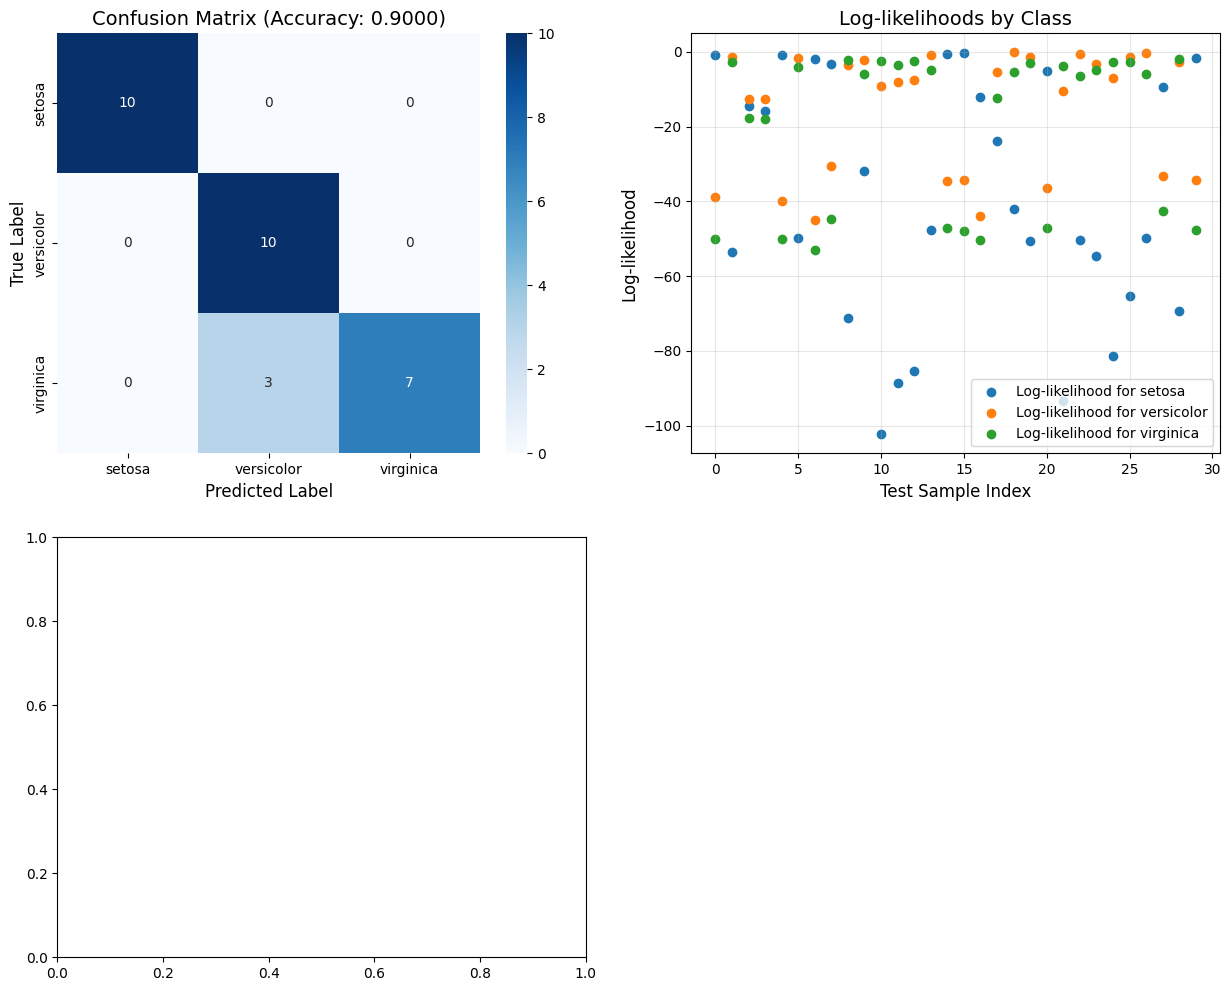

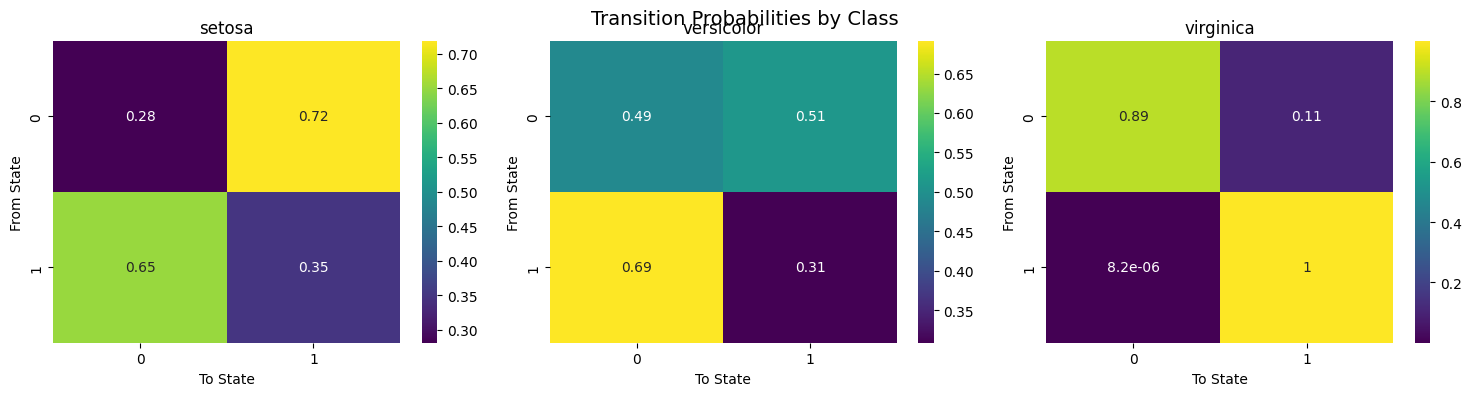

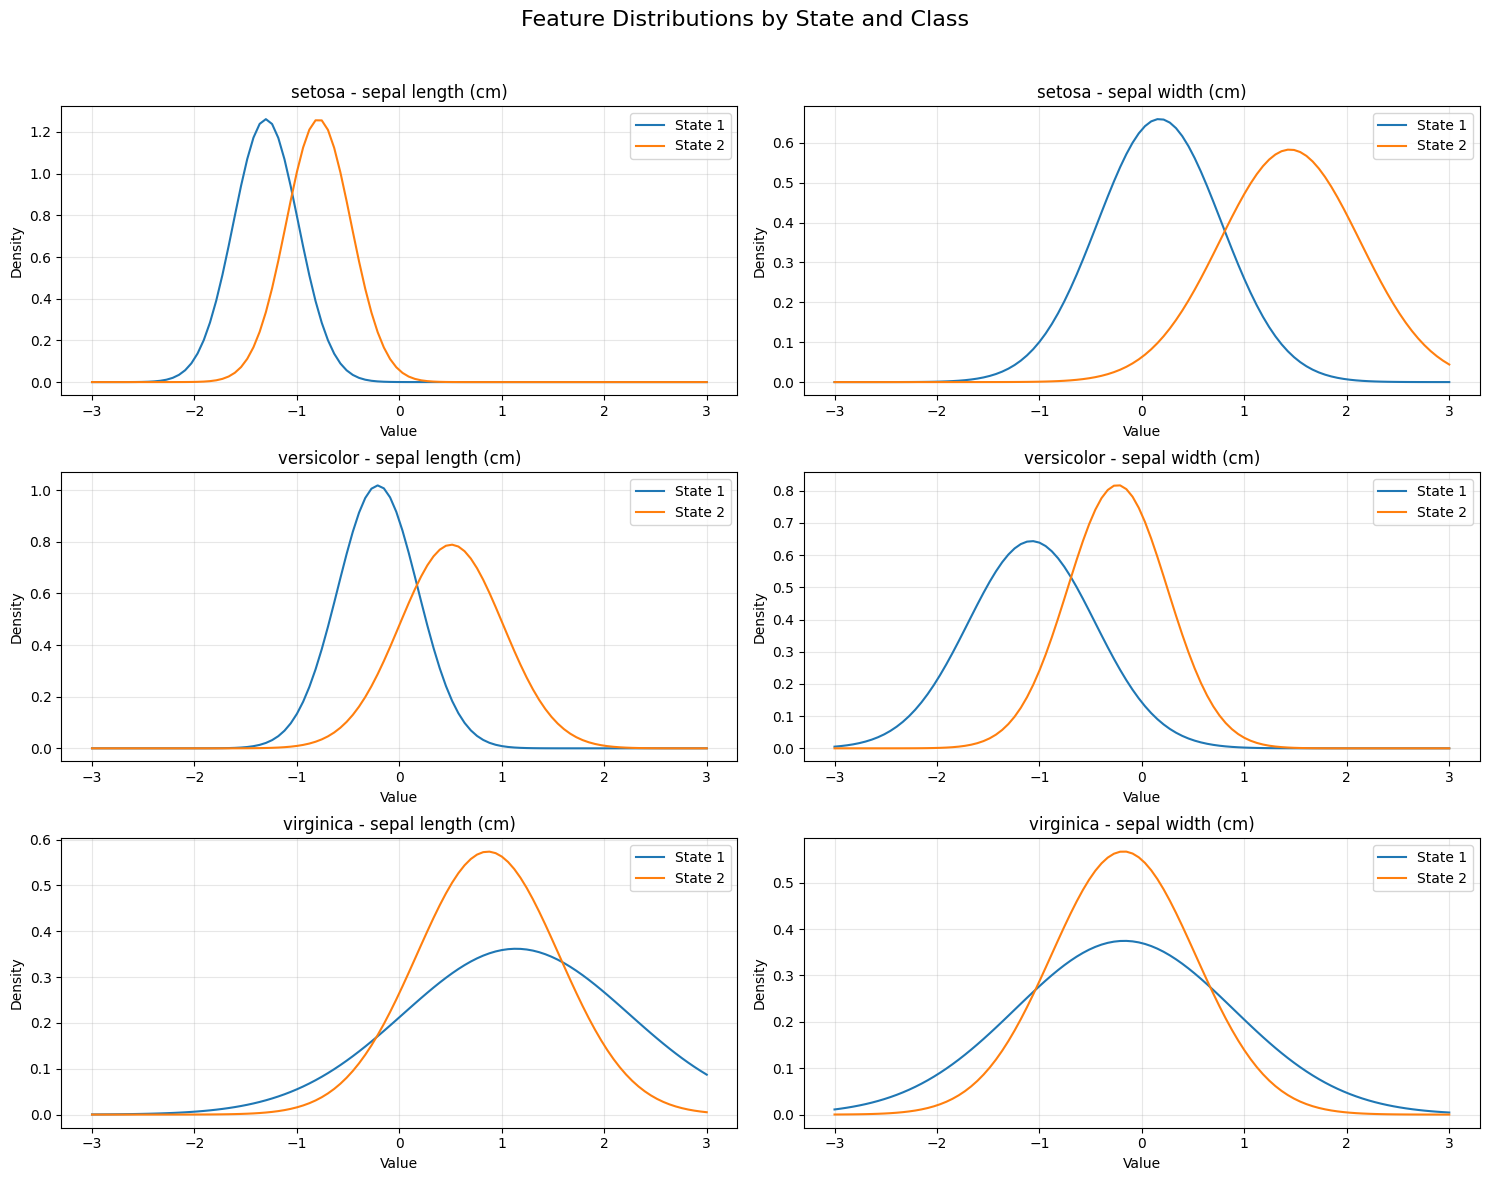

In [2]:
# Train and evaluate

def train_and_evaluate_improved_hmm():
    """Train an improved HMM on the Iris dataset and evaluate its performance."""
    # Load the Iris dataset
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train separate HMMs for each class
    hmms = []
    n_features = X_train.shape[1]

    for i in range(3):  # Three classes in Iris
        # Create model with optimal number of states
        hmm = ImprovedHiddenMarkovModel(n_states=2, n_features=n_features, random_state=42+i)

        # Get class samples
        X_class = X_train[y_train == i]

        # Make sure we have enough samples
        if len(X_class) < 5:
            indices = np.random.choice(len(X_class), size=10, replace=True)
            X_class = X_class[indices]

        # Train the model
        print(f"\nTraining HMM for class {iris.target_names[i]}:")
        hmm.fit(X_class, max_iter=50, tol=1e-4, verbose=True)
        hmms.append(hmm)

    # Predict on test set
    y_pred = np.zeros(X_test.shape[0], dtype=int)

    # Keep track of log-likelihoods for visualization
    all_log_likelihoods = np.zeros((X_test.shape[0], 3))

    for i in range(X_test.shape[0]):
        sample = X_test[i:i+1]
        log_likelihoods = np.zeros(3)

        for j, hmm in enumerate(hmms):
            try:
                log_likelihoods[j] = hmm.score(sample)
                all_log_likelihoods[i, j] = log_likelihoods[j]
            except Exception as e:
                print(f"Error scoring sample {i} with class {j} model: {e}")
                log_likelihoods[j] = -np.inf
                all_log_likelihoods[i, j] = -np.inf

        y_pred[i] = np.argmax(log_likelihoods)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    report = classification_report(y_test, y_pred, target_names=iris.target_names)
    print("\nClassification Report:")
    print(report)

    # Visualize results
    plt.figure(figsize=(15, 12))

    # Plot confusion matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.4f})', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    # Plot log-likelihoods for each sample and class
    plt.subplot(2, 2, 2)
    for i, class_name in enumerate(iris.target_names):
        plt.scatter(range(len(y_test)), all_log_likelihoods[:, i], label=f'Log-likelihood for {class_name}')
    plt.title('Log-likelihoods by Class', fontsize=14)
    plt.xlabel('Test Sample Index', fontsize=12)
    plt.ylabel('Log-likelihood', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot transition matrices
    plt.subplot(2, 2, 3)
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    plt.suptitle('Transition Probabilities by Class', fontsize=14)

    for i, (hmm, class_name) in enumerate(zip(hmms, iris.target_names)):
        sns.heatmap(hmm.transition_probs, annot=True, cmap='viridis', ax=axs[i])
        axs[i].set_title(f'{class_name}')
        axs[i].set_xlabel('To State')
        axs[i].set_ylabel('From State')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Plot feature distributions by state
    plt.figure(figsize=(15, 12))
    plt.suptitle('Feature Distributions by State and Class', fontsize=16)

    for i, (hmm, class_name) in enumerate(zip(hmms, iris.target_names)):
        for j in range(min(2, n_features)):  # Plot first 2 features
            plt.subplot(3, 2, i*2 + j + 1)
            x = np.linspace(-3, 3, 100)

            for s in range(hmm.n_states):
                mean = hmm.means[s, j]
                std = np.sqrt(hmm.covariances[s, j])
                y = np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
                plt.plot(x, y, label=f'State {s+1}')

            plt.title(f'{class_name} - {iris.feature_names[j]}', fontsize=12)
            plt.xlabel('Value', fontsize=10)
            plt.ylabel('Density', fontsize=10)
            plt.legend()
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    return hmms, accuracy, conf_matrix, report


if __name__ == "__main__":
    hmms, accuracy, conf_matrix, report = train_and_evaluate_improved_hmm()
    plt.show()